In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics

from wordcloud import WordCloud, STOPWORDS

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import itertools

import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from datasets import Dataset, DatasetDict, ClassLabel, Value, Features
from transformers import AutoTokenizer
from transformers import TFAutoModel
from transformers import TFAutoModelForSequenceClassification

from sklearn.preprocessing import StandardScaler

from torch.nn.functional import cross_entropy
import umap

In [18]:
tdf = pd.read_csv('Data\\twitter_training.csv')
vdf = pd.read_csv('Data\\twitter_validation.csv')

In [19]:
tdf = tdf.replace("Irrelevant", "Neutral")

In [4]:
tdf

,ID,Topic,Sentiment,Comment
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


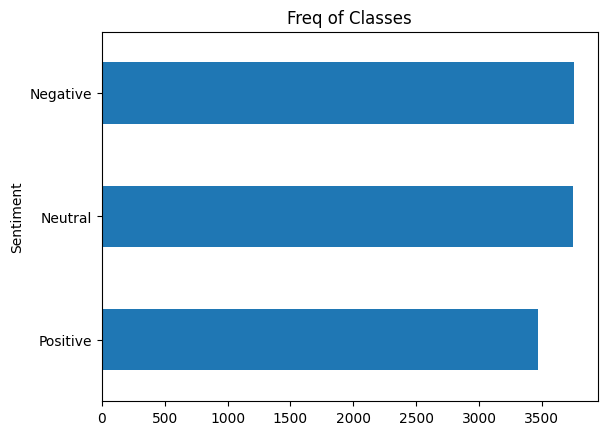

In [22]:
tdf['Sentiment'].value_counts(ascending=True).plot.barh()
plt.title('Freq of Classes')
plt.show()

In [5]:
y = 1
for index, row in tdf.iterrows():
    if y >= 2:
        tdf = tdf.drop(index)
    if y == 6:
        y = 1
    else:
        y= y + 1

In [6]:
z = 0
for index, row in tdf.iterrows():
    if row["Sentiment"] == "Neutral":
        if z > 3750:
            tdf = tdf.drop(index)
        else:
            z = z + 1
    else:
        pass

In [23]:
TopicList = []
Sentimentlist = []
commentstring = ""

for x in tdf.iterrows():
    TopicList.append(x[1]["Topic"])
    Sentimentlist.append(x[1]["Sentiment"])
    commentstring = commentstring + str(x[1]["Comment"])
    

In [24]:
cTopiclist = Counter(TopicList)
cSentimentlist = Counter(Sentimentlist)
commentwordlist = commentstring.split(" ")
ccommentwordlist = Counter(commentwordlist)

In [10]:
comment_words

'im getting on borderlands and i will murder you all , so i spent a few hours making something for fun. . . if you don\'t know i am a huge @borderlands fan and maya is one of my favorite characters. so i decided to make myself a wallpaper for my pc. . here is the original image versus the creation i made :) enjoy! pic.twitter.com/mlsi5wf9jg rock-hard la varlope, rare & powerful, handsome jackpot, borderlands 3 (xbox) dlvr.it/rmtrgf that was the first borderlands session in a long time where i actually had a really satisfying combat experience. i got some really good kills the biggest dissappoinment in my life came out a year ago fuck borderlands 3 we finished borderlands 3 finally yas! thank you for hanging out everyone! it was fun. i will try to stream tomorrow but if not i might so some irl streams while awayu. we shall see. thank you so much for the raids @mompou_mumpow @megamagwitch and @kfdmitch. man gearbox really needs to fix this dissapointing drops in the new borderlands 3 dlc

In [14]:
comment_words = ''
for index, row in tdf.iterrows():
     
    # typecaste each val to string
    val = str(row["Comment"])
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

In [15]:
comment_words = comment_words.replace("fuck", "FWord")
comment_words = comment_words.replace("fucking", "FWording")
comment_words = comment_words.replace("shit", "poop")

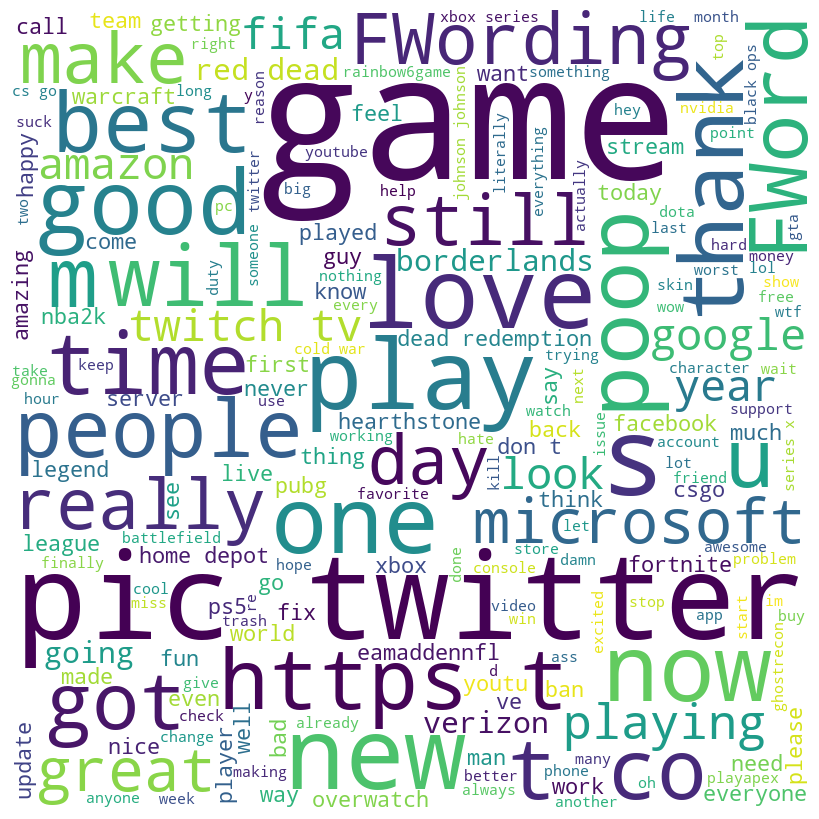

In [16]:

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [25]:
print(cTopiclist.most_common(10))
print(cSentimentlist.most_common(4))
print(ccommentwordlist.most_common(10))
print(len(set(ccommentwordlist)))

[('Microsoft', 400), ('LeagueOfLegends', 399), ('Verizon', 397), ('CallOfDutyBlackopsColdWar', 396), ('ApexLegends', 396), ('Dota2', 394), ('WorldOfCraft', 394), ('NBA2K', 392), ('Battlefield', 391), ('FIFA', 390)]
[('Negative', 3757), ('Neutral', 3751), ('Positive', 3472)]
[('.', 5876), ('the', 5449), ('', 5210), ('to', 4093), ('and', 3533), ('a', 3240), ('I', 3104), ('of', 2738), ('is', 2549), ('for', 2246)]
38767


In [20]:
def Cleaning(x):
    lemmatizer = WordNetLemmatizer()
    x = str(x)
    na = nltk.regexp_tokenize(x.lower(), r'(\b[\w]{2,}\b)')
    naa = []
    for z in na:
        naa.append(lemmatizer.lemmatize(z))
    nnaa = " ".join(naa)
    return nnaa

def RSW(x):
    x = str(x)
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.regexp_tokenize(x.lower(), r'(\b[\w]{2,}\b)')
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    nt = " ".join(filtered_sentence)
    return nt

#Creating Lem With Stop
for index, row in tdf.iterrows():
    oa = row["Comment"]
    g = row.name
    tdf.loc[g, "clean_Comment"] = Cleaning(oa)

#Creating No Lem With out Stop
for index, row in tdf.iterrows():
    oa = row["Comment"]
    g = row.name
    tdf.loc[g, "No_Stop_Words_Comment"] = RSW(oa)
#Creating Lem With Out Stop
for index, row in tdf.iterrows():
    oa = row["Comment"]
    g = row.name
    ns = Cleaning(oa)
    nns = RSW(ns)
    tdf.loc[g, "No_Stop_Words_Lemmatized_Comment"] = nns
    

In [21]:
X_train, X_test, y_train, y_test = train_test_split(tdf, tdf["Sentiment"], test_size=0.20, random_state=42)

In [22]:
def TheOne(typeofabstract, binary, ngram):
            pipeline = Pipeline([("Vec", CountVectorizer(binary= binary, ngram_range=(1, ngram))), ("Clf", LogisticRegression(max_iter= 3000))])
            scores = cross_validate(pipeline,
                X_train[typeofabstract],
                y_train,
                cv=10, 
                scoring=['f1_macro'])
            pipeline.fit(X_train[typeofabstract], y_train)
            y_true = list(X_test["Sentiment"])
            y_pred = pipeline.predict(X_test[typeofabstract])
            stufflist = []
            stufflist.append(typeofabstract)
            if binary == True:
                stufflist.append("Binary")
            else:
                stufflist.append("Non-Binary") 
            if ngram == 1:
                stufflist.append("1_ngram") 
            else:
                stufflist.append("2_ngram")
            return metrics.f1_score(y_true, y_pred, average='macro'), scores, stufflist

In [23]:
for index, row in tdf.iterrows():
    if row["Comment"] == float:
        tdf.drop(row)

In [24]:
tdf['Comment'] = tdf['Comment'].astype(str)
tdf['clean_Comment'] = tdf['clean_Comment'].astype(str)
tdf['No_Stop_Words_Comment'] = tdf['No_Stop_Words_Comment'].astype(str)
tdf['No_Stop_Words_Lemmatized_Comment'] = tdf['No_Stop_Words_Lemmatized_Comment'].astype(str)

In [10]:
test_f1_list = []
cv_f1_list = []
cv_f1t_list = []
event_list = []
a, b, c = TheOne("clean_Comment", True, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("1")
a, b, c = TheOne("No_Stop_Words_Comment", True, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("2")
a, b, c = TheOne("No_Stop_Words_Lemmatized_Comment", True, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("4")
a, b, c = TheOne("clean_Comment", False, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("5")
a, b, c = TheOne("No_Stop_Words_Comment", False, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("6")
a, b, c = TheOne("No_Stop_Words_Lemmatized_Comment", False, 1)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("8")
a, b, c = TheOne("clean_Comment", True, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("9")
a, b, c = TheOne("No_Stop_Words_Comment", True, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("10")
a, b, c = TheOne("No_Stop_Words_Lemmatized_Comment", True, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("12")
a, b, c = TheOne("clean_Comment", False, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("13")
a, b, c = TheOne("No_Stop_Words_Comment", False, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])
print("14")
a, b, c = TheOne("No_Stop_Words_Lemmatized_Comment", False, 2)
test_f1_list.append(a)
cv_f1_list.append(b["test_f1_macro"])
event_list.append(c)
cv_f1t_list.append(b["fit_time"])

1
2
4
5
6
8
9
10
12
13
14


In [11]:
ndf = {}
tbl = []
i = 1
for x in range(1, 17):
    ndf[x] = {"Lemmatized" : "", "stop_words" : "", "binarized" : "", "n_gram" : "", "mean_f1" : "", "median_f1" : "", "std_f1" : "", "total_fit_time" : "", "test_f1" : "", "scenario" : ""}
for x in event_list:
    new_list = []
    if "abstract" == x[0]:
        ndf[i]["Lemmatized"] = "Not_Lemmatized"
        ndf[i]["stop_words"] = "Included"
        new_list.append("Not_Lemmatized Stop Words Included")
    elif "clean_abstract" == x[0]:
        ndf[i]["Lemmatized"] = "Is_Lemmatized"
        ndf[i]["stop_words"] = "Included"
        new_list.append("Is_Lemmatized Stop Words Included")
    elif "No_Stop_Words_abstract" == x[0]:
        ndf[i]["Lemmatized"] = "Not_Lemmatized"
        ndf[i]["stop_words"] = "Not_Included"
        new_list.append("Not_Lemmatized Stop Words Not Included")
    else:
        ndf[i]["Lemmatized"] = "Is_Lemmatized"
        ndf[i]["stop_words"] = "Not_Included"
        new_list.append("Is_Lemmatized Stop Words Not Included")
    if x[1] == "Binary":
        ndf[i]["binarized"] = "Yes"
        new_list.append("Is Binarized")
    else:
        ndf[i]["binarized"] = "No"
        new_list.append("Isn't Binarized")
    if x[2] == "1_ngram":
        ndf[i]["n_gram"] = "1"
        new_list.append("Is 1ngram")
    else:
        ndf[i]["n_gram"] = "2"
        new_list.append("Is 2ngram")
    tbl.append(" ".join(new_list))
    ndf[i]["scenario"] = " ".join(new_list)
    i = i + 1
i = 1
for x in test_f1_list:
    ndf[i]["test_f1"] = x
    i = i + 1
i = 1
for x in cv_f1t_list:
    fn = 0
    for y in x:
        fn = y + fn
    ndf[i]["total_fit_time"] = fn
    i = i + 1
i = 1
for x in cv_f1_list:
    ndf[i]["mean_f1"] = np.mean(x)
    i = i + 1
i = 1
for x in cv_f1_list:
    ndf[i]["median_f1"] = np.median(x)
    i = i + 1
i = 1
for x in cv_f1_list:
    ndf[i]["std_f1"] = np.std(x)
    i = i + 1

nndf = pd.DataFrame(ndf)
nndf = pd.DataFrame.transpose(nndf)
display(nndf)
nndf.to_csv('model_card.csv')

,Lemmatized,stop_words,binarized,n_gram,mean_f1,median_f1,std_f1,total_fit_time,test_f1,scenario
1,Is_Lemmatized,Not_Included,Yes,1,0.842138,0.841711,0.006002,21.168037,0.849724,Is_Lemmatized Stop Words Not Included Is Binar...
2,Is_Lemmatized,Not_Included,Yes,1,0.848297,0.847922,0.003406,15.891392,0.857932,Is_Lemmatized Stop Words Not Included Is Binar...
3,Is_Lemmatized,Not_Included,Yes,1,0.838762,0.839229,0.004832,14.714664,0.848265,Is_Lemmatized Stop Words Not Included Is Binar...
4,Is_Lemmatized,Not_Included,No,1,0.843496,0.843805,0.005156,33.600509,0.850241,Is_Lemmatized Stop Words Not Included Isn't Bi...
5,Is_Lemmatized,Not_Included,No,1,0.847511,0.847207,0.004688,24.572387,0.856463,Is_Lemmatized Stop Words Not Included Isn't Bi...
6,Is_Lemmatized,Not_Included,No,1,0.840154,0.840543,0.004866,24.463512,0.848166,Is_Lemmatized Stop Words Not Included Isn't Bi...
7,Is_Lemmatized,Not_Included,Yes,2,0.91236,0.912034,0.004593,78.444888,0.917584,Is_Lemmatized Stop Words Not Included Is Binar...
8,Is_Lemmatized,Not_Included,Yes,2,0.909438,0.909215,0.003857,62.453621,0.914807,Is_Lemmatized Stop Words Not Included Is Binar...
9,Is_Lemmatized,Not_Included,Yes,2,0.908107,0.907096,0.004317,60.321469,0.915379,Is_Lemmatized Stop Words Not Included Is Binar...
10,Is_Lemmatized,Not_Included,No,2,0.911589,0.910805,0.004995,160.476145,0.916391,Is_Lemmatized Stop Words Not Included Isn't Bi...


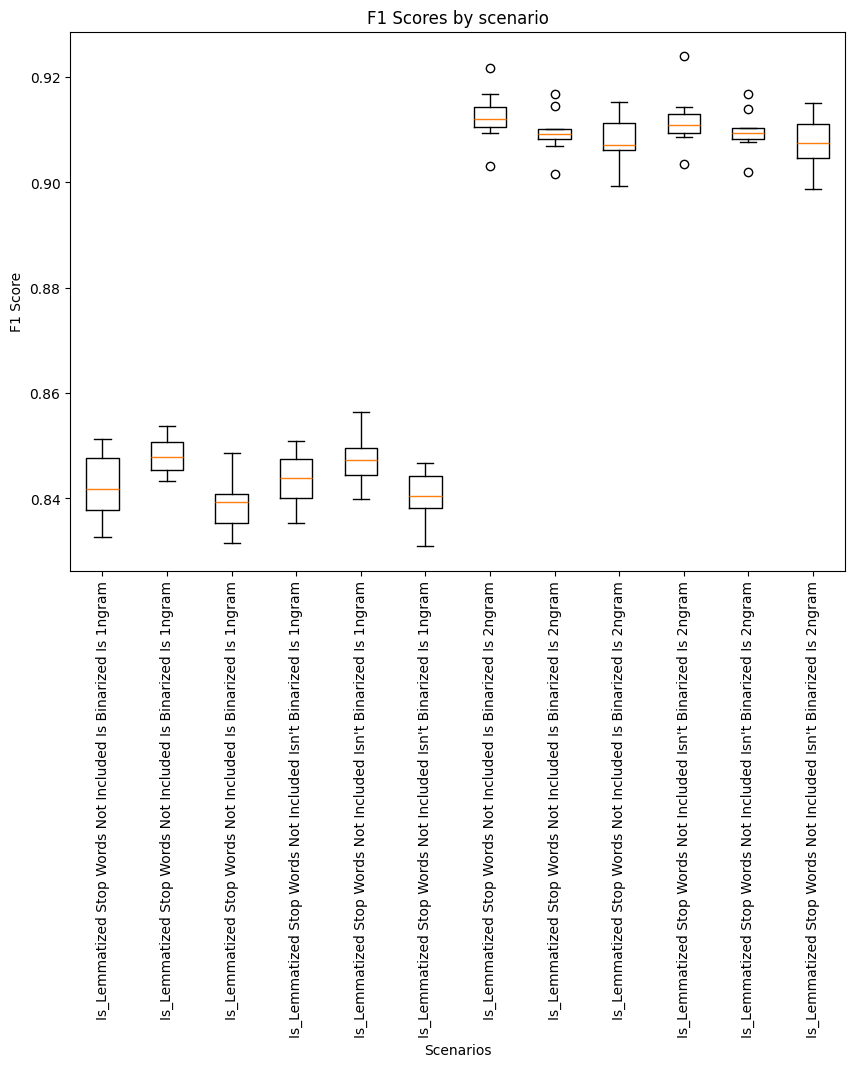

In [12]:
data = []
for x in cv_f1_list:
    
    data.append(x)
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

ax.boxplot(data)
ax.set_xticklabels(tbl, rotation=90)
i = 1

plt.xlabel("Scenarios")
plt.ylabel("F1 Score")
plt.title("F1 Scores by scenario")
plt.show()

In [25]:
def TheOneV2(typeofabstract, binary, ngram):
            pipeline = Pipeline([("Vec", CountVectorizer(binary= binary, ngram_range=(1, ngram))), ("Clf", LogisticRegression(max_iter= 3000))])
            scores = cross_validate(pipeline,
                X_train[typeofabstract],
                y_train,
                cv=10, 
                scoring=['f1_macro'])
            pipeline.fit(X_train[typeofabstract], y_train)
            y_true = list(X_test["Sentiment"])
            y_pred = pipeline.predict(X_test[typeofabstract])
            return y_true, y_pred

In [26]:
y_true, y_pred = TheOneV2("No_Stop_Words_Lemmatized_Comment", False, 2)

In [22]:
y_true

['Neutral',
 'Positive',
 'Negative',
 'Neutral',
 'Positive',
 'Negative',
 'Positive',
 'Neutral',
 'Positive',
 'Neutral',
 'Positive',
 'Positive',
 'Neutral',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Neutral',
 'Negative',
 'Positive',
 'Neutral',
 'Positive',
 'Neutral',
 'Positive',
 'Negative',
 'Positive',
 'Neutral',
 'Neutral',
 'Negative',
 'Positive',
 'Negative',
 'Neutral',
 'Positive',
 'Positive',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Neutral',
 'Neutral',
 'Positive',
 'Positive',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'P

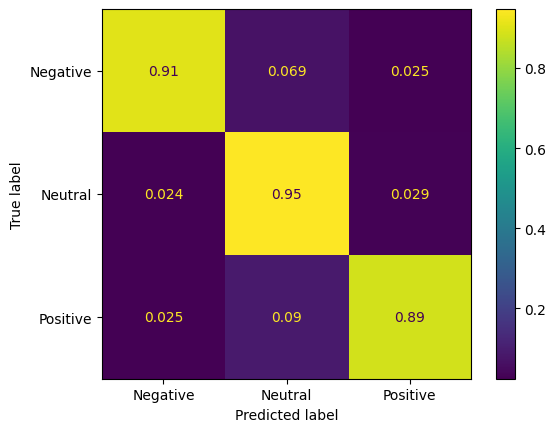

In [27]:
metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred,normalize= "true")
plt.show()

In [3]:
import dill

In [33]:
X_train['Comment'] = X_train['Comment'].astype(str)
X_train['clean_Comment'] = X_train['clean_Comment'].astype(str)
X_train['No_Stop_Words_Comment'] = X_train['No_Stop_Words_Comment'].astype(str)
X_train['No_Stop_Words_Lemmatized_Comment'] = X_train['No_Stop_Words_Lemmatized_Comment'].astype(str)

In [34]:
def Cleaning(x):
    lemmatizer = WordNetLemmatizer()
    noc = []
    for y in x:
        oa = y
        na = nltk.regexp_tokenize(oa.lower(), r'(\b[\w]{2,}\b)')
        naa = []
        for z in na:
            naa.append(lemmatizer.lemmatize(z))
        nnaa = " ".join(naa)
        noc.append(nnaa)
    return noc

pipeline = Pipeline([("Func", FunctionTransformer(Cleaning)),("Vec", CountVectorizer(ngram_range=(1, 2))), ("Clf", LogisticRegression())])
pipeline.fit(X_train['Comment'], y_train)
dill.settings['recurse'] = True
dill.dump(pipeline, open('model.pkl','wb'))

c:\Users\ruthe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
test_strings = ["This is the best model ever.",
"This is the worst model ever.",
"I have seen better models but this one is okay."]
model_saved = dill.load(open('model.pkl','rb'))
y_pred = model_saved.predict(test_strings)
y_pred

array(['Positive', 'Negative', 'Positive'], dtype=object)